In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sc
import h5py as h5
import yaml
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
#numpy print options
np.set_printoptions(precision=5)

## Setup

In [5]:
lat_file = "../build/Executables/Examples/example_param_four_sites.yml"
#read yaml file
with open(lat_file, 'r') as stream:
    system = yaml.safe_load(stream)["system"]
    name = system["name"]
    nx = system["nions"]
    nt = system["Nt"]
    beta = system["beta"]
    delta = beta/nt
    U = system["U"]
    mu = system["mu"]
    adjacency = system["adjacency"]
    hopping = system["hopping"]
    positions = system["positions"]
print(f"Lattice: {name}")
print(f"Nt:      {nt}")
print(f"beta:    {beta}")
print(f"U:       {U}")
print(f"mu:      {mu}")

hop = np.zeros((nx, nx))
for n, (i, j) in enumerate(adjacency):
    hop[i, j] = hopping[n]
    hop[j, i] = hopping[n]

Lattice: 1x2 Honeycomb
Nt:      32
beta:    8.0
U:       2.0
mu:      0


## Compute Eigenenergies

In [6]:
def count_set_bits(n):
    count = 0
    while n:
        count += n & 1
        n >>= 1
    return count


def count_flips(state, x, y):
    if x > y:
        x, y = y, x
    count = 0
    state >>= x + 1
    for i in range(y - x):
        count += state & 1
        state >>= 1
    return count
from scipy.special import comb

In [7]:
eps, UH = np.linalg.eigh(hop)
# print(hop)
sub_basis = [[] for _ in range(nx + 1)]
momentum = [[] for _ in range(nx + 1)]
for state in range(2**nx):
    count = count_set_bits(state)
    sub_basis[count].append(state)
    # momentum[count].append(state == shift_state(state, nx))

hoppings = [[] for _ in range(nx + 1)]
for n in range(nx + 1):
    for index, state in enumerate(sub_basis[n]):
        for x in range(nx):
            ind = 2**x
            if state & ind == ind:
                for y in range(x, nx):
                    if hop[x, y] != 0.0:
                        ind2 = 2**y
                        if state & ind2 == 0:
                            state2 = state - ind + ind2
                            out_index = np.where(np.array(sub_basis[n]) == state2)[0][0]
                            sign = (-1) ** count_flips(state, x, y)
                            hoppings[n].append((index, out_index, sign * hop[x, y]))
# print(sub_basis[2])
# print(hoppings[2])
Es0 = [[[] for _ in range(nx + 1)] for _ in range(nx + 1)]
Ls = [[[] for _ in range(nx + 1)] for _ in range(nx + 1)]
for nu in range(nx + 1):
    cu = int(comb(nx, nu))
    for nd in range(nx + 1):
        cd = int(comb(nx, nd))
        cn = cu * cd
        H = np.zeros((cn, cn))
        K = np.zeros((cn, cn))
        V = np.zeros((cn, cn))
        # basis = []
        for u, stateu in enumerate(sub_basis[nu]):
            for d, stated in enumerate(sub_basis[nd]):
                index = u * cd + d
                # basis.append(momentum[nu][u] and momentum[nd][d])
                overlap = count_set_bits(stateu & stated)
                V[index, index] = U * overlap
        for index1, index2, amp in hoppings[nu]:
            for d, stated in enumerate(sub_basis[nd]):
                K[index1 * cd + d, index2 * cd + d] = -amp  # *0.5
                K[index2 * cd + d, index1 * cd + d] = -amp  # *0.5
        for index1, index2, amp in hoppings[nd]:
            for u, stateu in enumerate(sub_basis[nu]):
                K[u * cd + index1, u * cd + index2] = -amp  # *0.5
                K[u * cd + index2, u * cd + index1] = -amp  # *0.5
        H = K + V
        # eigs = np.linalg.eigvalsh(H)
        eigs, eigv = np.linalg.eigh(H)
        eigs = eigs - (nu + nd) * U / 2

        #! Something goes wrong here for non bipartite lattices
        A = sc.linalg.expm(-K * delta / 2)
        B = sc.linalg.expm(-V * delta)
        C = np.matmul(A, B)
        C = np.matmul(C, A)
        eigs = -np.log(np.linalg.eigvalsh(C) ** nt) / beta - (nu + nd) * U / 2

        Es0[nu][nd] = eigs
        Ls[nu][nd] = eigv.T

In [8]:
Es = [[[] for _ in range(nx + 1)] for _ in range(nx + 1)]
for nu in range(nx + 1):
    for nd in range(nx + 1):
        Es[nu][nd] = Es0[nu][nd] + (nu + nd) * mu

## Overlaps


In [9]:
# function that takes integer, shifts bits by two positions (loop with given modulus) and returns new interger
def shift_state(state, n, shifts={0: 2, 1: 3, 2: 0, 3: 1}):
    bits = [int((state & 2**i) > 0) for i in range(n)]
    bits_out = [bits[shifts[i]] for i in range(n)]
    return sum([bits_out[i] * 2**i for i in range(n)])

class bits_c:
    def __init__(self, n):
        self.n = n

    def __call__(self, state: list) -> int:
        return sum([state[i] * 2**i for i in range(self.n)])

    def __getitem__(self, state: int) -> list:
        return [(state & 2**i) > 0 for i in range(self.n)]

def c_x(n, x):
    bits = bits_c(nx)
    basis_from = sub_basis[n]
    # print(basis_from)
    basis_to = sub_basis[n - 1]
    # print(basis_to)
    reverse_map = {state: index for index, state in enumerate(basis_to)}
    out = np.zeros((len(basis_to), len(basis_from)))
    # print(out)
    for i, state in enumerate(basis_from):
        stateb = bits[state]
        if stateb[x]:
            stateb[x] = False
            state_out = bits(stateb)
            j = reverse_map[state_out]
            factor = 1
            for y in range(0, x):
                if stateb[y]:
                    factor *= -1
            out[j, i] = factor
    return out

# def c(n):
#     # Quickfix
#     c_xs = [c_x(n, x) for x in range(nx)]
#     c_k0p = (c_xs[0] + c_xs[1] + c_xs[2] + c_xs[3]) / 4
#     c_k0m = (c_xs[0] - c_xs[1] + c_xs[2] - c_xs[3]) / 4
#     c_k1p = (c_xs[0] + c_xs[1] - c_xs[2] - c_xs[3]) / 4
#     c_k1m = (c_xs[0] - c_xs[1] - c_xs[2] + c_xs[3]) / 4
#     return c_k0p, c_k0m, c_k1p, c_k1m

def c(n):
    # transform = np.array([0, 0, -0.866025403784439, -0.5, -0.577350269189626, -0.577350269189626, 0.288675134594813, -0.5, 0.788675134594813, -0.211324865405187, 0.288675134594813, -0.5, -0.211324865405187, 0.788675134594813, 0.288675134594813, -0.5]).reshape((4,4)) #tetrahedron
    # transform = np.array([0.5, 0.5, 0.5, -0.5, -0.5, 0.5, -0.5, -0.5, 0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 0.5, -0.5]).reshape((4,4)) #four sites
    # transform = transform[[0,2,3,1]]
    transform = UH  #! maybe transpose
    c_xs = [c_x(n, x) for x in range(nx)]
    c_ks = [
        np.sum([c_xs[i] * transform[i, j] for i in range(nx)], axis=0)
        for j in range(nx)
    ]
    return c_ks

In [10]:
def overlapGS(nu, nd, mu=0.0):
    out = []
    state_in = Ls[nu][nd][0]
    state_in = state_in.reshape(len(sub_basis[nu]), len(sub_basis[nd]))
    # applying to spin up
    states_out = Ls[nu - 1][nd]
    states_out = [
        state.reshape(len(sub_basis[nu - 1]), len(sub_basis[nd]))
        for state in states_out
    ]
    dEs = np.array(Es[nu - 1][nd]) - Es[nu][nd][0] - mu
    for c_k in c(nu):
        overlaps = np.einsum("nzd, zu, ud -> n", states_out, c_k, state_in) ** 2
        out.append(np.array([*list(zip(dEs, overlaps))]))

    state_out = state_in
    states_in = Ls[nu + 1][nd]
    states_in = [
        state.reshape(len(sub_basis[nu + 1]), len(sub_basis[nd])) for state in states_in
    ]
    dEs = -np.array(Es[nu + 1][nd]) + Es[nu][nd][0] - mu
    for c_k in c(nu + 1):
        overlaps = np.einsum("ud, uz, nzd -> n", state_out, c_k, states_in) ** 2
        out.append(np.array([*list(zip(dEs, overlaps))]))
    return [
        [k, oo[1] * np.exp(-np.abs(oo[0])), oo[0]]
        for k, o in enumerate(out)
        for oo in o
    ]

def overlap(nu, nd):
    states_in = Ls[nu][nd]
    states_in = [
        state.reshape(len(sub_basis[nu]), len(sub_basis[nd])) for state in states_in
    ]
    # applying to spin up
    states_out = Ls[nu - 1][nd]
    states_out = [
        state.reshape(len(sub_basis[nu - 1]), len(sub_basis[nd]))
        for state in states_out
    ]
    out = []
    for c_k in c(nu):
        # print(np.shape(states_out), np.shape(c_k), np.shape(states_in))
        out.append(np.einsum("nzd, zu, mud -> nm", states_out, c_k, states_in) ** 2)
    # applying to spin down
    # states_out = Ls[nu][nd - 1]
    # for c_k in c(nd):
    #     states_out = [
    #         state.reshape(len(sub_basis[nu]), len(sub_basis[nd - 1]))
    #         for state in states_out
    #     ]
    #     print(np.einsum("nuz, zd, ud -> n", states_out, c_k, state_in) ** 2)
    return out

In [11]:

# beta = 6.0
# nt = 256 + 1
delta = beta / nt
nts = np.arange(nt+1)
expnts = np.exp(-nts * delta)
expntsb = np.exp(nts * delta - beta)
corrs = np.zeros((nx, nt+1))
Z = 0
for nu in range(1, nx + 1):
    for nd in range(nx + 1):
        E_is = Es[nu][nd]
        E_js = Es[nu - 1][nd]
        exp_is = np.array([expntsb**E_i for E_i in E_is])
        exp_js = np.array([expnts**E_j for E_j in E_js])
        ovs = overlap(nu, nd)
        corrs += np.einsum("kji, it, jt -> kt", ovs, exp_is, exp_js)
        Z += np.sum(np.exp(-E_is * beta))
corrs /= Z

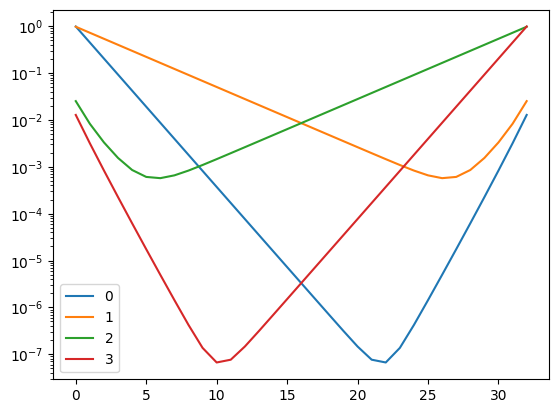

In [12]:
import matplotlib.pyplot as plt

plt.clf()
plt.yscale("log")
for k in range(nx):
    # plt.plot(nts, np.exp(-nts*1)*np.exp(nts*2-2))
    plt.plot(nts, corrs[k], label=k)
plt.legend()
plt.show()

In [13]:
with open(lat_file, 'r') as stream:
    outfile = yaml.safe_load(stream)["fileIO"]["h5file"]
    print(outfile)

example_four_sites_p.h5


In [15]:
with h5.File("../build/" + outfile, "a") as h5f:
    node = h5f[name]
    grp = node.require_group("Exact")
    grp = grp.require_group("correlators")
    grp = grp.require_group("single")
    grp = grp.require_group("particle")
    grp.create_dataset("k", data=corrs)